In [1]:
import os
import h5py

import numpy as np
from numpy.typing import NDArray

import pandas as pd
import FFModel

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import albumentations as A
import albumentations.pytorch.transforms as Atorch

import pytorch_lightning as pl

import segmentation_models_pytorch as smp

import chabud
# Wird gebraucht um das Modell laden zu können. :/
from chabud import BandExtractor, NBR, NDVI, GNDVI, EVI, AVI, SAVI, NDMI, MSI, GCI, BSI, NDWI, NDSI, NDGI

from pathlib import Path
from tqdm.auto import tqdm


from trimesh.voxel.runlength import dense_to_brle
from pathlib import Path
from collections import defaultdict

from typing import Any, Union, Dict, Literal

import skimage as ski

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


# WICHTIG: Nur so viele CPUs benutzen wie unserem Job zugeteilt sind.
#   Sonst wird alles *sehr* langsam!
N_CPUS = int(os.getenv("SLURM_CPUS_PER_TASK", 1))
torch.set_num_threads(N_CPUS)

In [2]:
BASEDIR = Path("/global/public/chabud-ecml-pkdd2023/")
CHECKPOINTDIR = BASEDIR / "checkpoints"
LOCALCHECKPOINTS = Path("lightning_logs/version_30/checkpoints/")
TRAININGFILE = BASEDIR / "train_eval.hdf5"
TESTFILE = BASEDIR / "test.hdf5"

list(LOCALCHECKPOINTS.glob("*.ckpt"))
#list(BASEDIR.glob("*.hdf5"))

[PosixPath('lightning_logs/version_30/checkpoints/epoch=29-step=780.ckpt')]

In [3]:
localCkpt = LOCALCHECKPOINTS / "epoch=29-step=780.ckpt"

In [4]:
if True:
    mdl = FFModel.FFModel.load_from_checkpoint(localCkpt, map_location="cpu")
    #mdl = chabud.FireModel.load_from_checkpoint(localCkpt, map_location="cpu")
    mdl.datafile = TRAININGFILE
    mdl.train_use_pre_fire = False
else:
    mdl = FFModel.FFModel(datafile=TRAININGFILE, 
                         channels=[256, 128, 64, 32, 16, 8], 
                         batch_size=16,
                         lr=0.001,
                         encoder="resnet34",
                         encoder_depth=3,
                         encoder_weights="imagenet",
                         loss="dice",
                         model="unet",
                         n_cpus = N_CPUS,
                         train_use_pre_fire=True,
                         train_transform=A.Compose([
                            A.VerticalFlip(p=0.5),       
                            A.HorizontalFlip(p=0.5),
                            A.Transpose(p=0.5),
                            A.RandomRotate90(p=0.5),
                            Atorch.ToTensorV2()
                        ]))



## Trainieren

Anstelle einer Trainingsschleife nutzen wir den PyTorch Lightning `Trainer` um das Trainieren zu koordinieren.

Training starten bis die maximale Anzahl an Epochen erreicht ist oder das Training stagniert.

In [5]:
if False:
    trainer = pl.Trainer(log_every_n_steps=5, max_epochs=30)
    trainer.fit(mdl)

In [6]:
def process_dataset(model, bands):
    #channels = np.stack([c(bands) for c in model.channels])
    with torch.set_grad_enabled(False):
        #pred = model.forward(torch.Tensor(channels[np.newaxis, ...])).sigmoid() > 0.5
        pred = model.forward(torch.Tensor(np.stack(bands)[np.newaxis, ...])).sigmoid() > 0.5
        pred = pred[0, 0, ...].detach().numpy()
        
    return pred

In [7]:
# class RandomModel:
#     def __init__(self, shape):
#         self.shape = shape
#         return

#     def __call__(self, input):
#         # input is ignored, just generate some random predictions
#         return np.random.randint(0, 2, size=self.shape, dtype=bool)
    
class PPModel:
    def __init__(self, model) -> None:
        self.model = model
        return
    
    def __call__(self, input, scene) -> Any:
        bands = FFModel.get_fire_bands(input["post"])
        pred = process_dataset(model = self.model, bands = bands)

        ## Post Processing goes here
        return pred

In [8]:
def retrieve_validation_fold(path: Union[str, Path], training = True) -> Dict[str, NDArray]:
    result = defaultdict(dict)
    with h5py.File(path, 'r') as fp:
        for uuid, values in fp.items():
            if training and values.attrs['fold'] != 0:
                continue
            
            result[uuid]['post'] = values['post_fire'][...].astype("float32") / 10000.0
            if not 'pre_fire' in values:
                result[uuid]['pre'] = np.zeros_like(result[uuid]['post'])
            else:
                result[uuid]['pre'] = values['pre_fire'][...].astype("float32") / 10000.0
            result[uuid]['delta'] = result[uuid]['pre'] - result[uuid]['post']
            if training:
                result[uuid]['mask'] = values["mask"][..., 0].astype("float32")

    return dict(result)


def compute_submission_mask(id: str, mask: NDArray):
    brle = dense_to_brle(mask.astype(bool).flatten())
    return {"id": id, "rle_mask": brle, "index": np.arange(len(brle))}

In [9]:
def IoUScore(prediction, mask):
    tp, fp, fn, tn = smp.metrics.get_stats(torch.from_numpy(prediction), torch.from_numpy(mask).long(), mode="binary")
    iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
    return iou

In [10]:
validation_fold = retrieve_validation_fold(TESTFILE, training = False)


In [11]:
# use a list to accumulate results
result = []

# instantiate the model
model = PPModel(model=mdl)
for uuid in validation_fold:
    input_images = validation_fold[uuid]

    # perform the prediction
    predicted = model(input_images, uuid)
    # convert the prediction in RLE format
    

    encoded_prediction = compute_submission_mask(uuid, predicted)
    result.append(pd.DataFrame(encoded_prediction))

In [12]:
# concatenate all dataframes
#submission_df = pd.concat(result)
#submission_df.to_csv('test_predictions_model4v8.csv', index=False)

In [13]:
validation_fold = retrieve_validation_fold(TRAININGFILE, training = True)

In [14]:
# use a list to accumulate results
result = []
scores = []
# instantiate the model
model = PPModel(model=mdl)
for uuid in validation_fold:
    input_images = validation_fold[uuid]

    # perform the prediction
    predicted = model(input_images, uuid)
    # convert the prediction in RLE format
    
    if 'mask' in input_images:
        score = IoUScore(predicted, input_images['mask'])
        scores.append(score)

    encoded_prediction = compute_submission_mask(uuid, predicted)
    result.append(pd.DataFrame(encoded_prediction))

In [15]:
allScore = np.mean(scores)
print(allScore)



0.5734267


In [16]:
# concatenate all dataframes
#submission_df = pd.concat(result)
#submission_df.to_csv('train_predictions_model4v8.csv', index=False)

7db22730-f011-40d9-a05b-657ea7fc960c_1
tensor(0.9378)


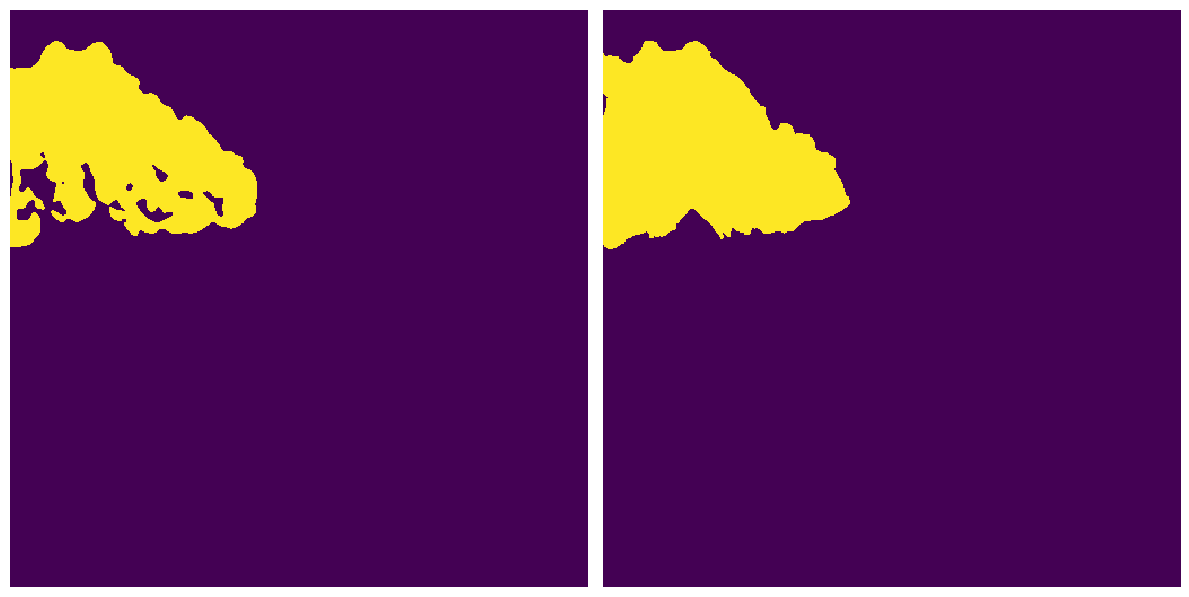

In [17]:
import random
uuids = []

for item in validation_fold:
    uuids.append(item)
    
uuid = random.choice(uuids)
print(uuid)
input_images = validation_fold[uuid]
predicted = model(input_images, uuid)
if 'mask' in input_images:
    mask = input_images['mask']
else:
    mask = predicted

score = IoUScore(predicted, mask)
print (score)

fig, ax =  plt.subplots(nrows=1, ncols=2, figsize=(12, 3*12))
ax[0].imshow(predicted, interpolation="nearest")
ax[0].axis("off")
ax[1].imshow(mask, interpolation="nearest")
ax[1].axis("off")
fig.tight_layout()